In [1]:
%%capture --no-stderr
%pip install --quiet -U langsmith langgraph langchain_community langchain-core==0.3.21 pydantic==2.8.2 pydantic-settings==2.5.2 packaging==23.2 google-genai==0.3.0

In [60]:
import os
from IPython.display import Image, display
from google.genai import Client
from google.genai.types import Tool, GenerateContentConfig, GoogleSearch
from typing import Literal, Union, Dict
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, RemoveMessage, ToolMessage
from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import MessagesState
from langgraph.checkpoint.memory import MemorySaver
from pydantic import BaseModel

In [50]:
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")

client = Client(
  api_key=GOOGLE_API_KEY,
  http_options= {'api_version': 'v1alpha'}
)

MODEL: str = "gemini-2.0-flash-exp"

config = {
  "configurable": {"thread_id": "1"},
  "generation_config": {"response_modalities": ["TEXT"]}
  }

In [ ]:
# Postgres DB

# # if you want to use postgres install these extra packages
# pip install langgraph-checkpoint-postgres psycopg psycopg-pool psycopg-binary

# # import these
# from psycopg_pool import ConnectionPool
# from langgraph.checkpoint.postgres import PostgresSaver

# # Extra Env variable
# NEON_DB_URI = os.getenv("NEON_DB_URI")

# # Connection pool for efficient database access
# connection_kwargs = {"autocommit": True, "prepare_threshold": 0}

# # Create a persistent connection pool
# pool = ConnectionPool(conninfo=NEON_DB_URI, max_size=50, kwargs=connection_kwargs)

# # Initialize PostgresSaver checkpointer
# checkpointer = PostgresSaver(pool)               # pass this checkpointer while compiling the graph
# checkpointer.setup()  # Ensure database tables are set up

memory: MemorySaver = MemorySaver()      # if you dont want to set postgres DB, just go with `MemorySaver()`

In [51]:
# State

class State(MessagesState):
    summary: str
    ask_human: bool

In [52]:
class RequestAssistance(BaseModel):  # You can modify it for Whatsapp
    """Escalate the conversation to an expert. Use this if you are unable to assist directly or if the user requires support beyond your permissions.

    To use this function, relay the user's 'request' so the expert can provide the right guidance.
    """

    request: str
    
google_search_tool = Tool(
    google_search = GoogleSearch()
)

tools = [google_search_tool]

# We used this binding method in `ChatGoogleGenerativeAI`, but I am using `Google sdk`
# I dont know how can I used tools in this
# If this issue is resolves, we can add RequestAssistance with it

# llm_with_tools = llm.bind_tools(tools + [RequestAssistance])   

In [53]:
# Helper Function
def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response,
        tool_call_id=ai_message.tool_calls[0]["id"],
    )


def human_node(state: State):
    new_messages = []
    if not isinstance(state["messages"][-1], ToolMessage):
        # Typically, the user will have updated the state during the interrupt.
        # If they choose not to, we will include a placeholder ToolMessage to
        # let the LLM continue.
        new_messages.append(
            create_response("No response from human.", state["messages"][-1])
        )
    return {
        # Append the new messages
        "messages": new_messages,
        # Unset the flag
        "ask_human": False,
    }

In [54]:
# Summarization

async def summarize_conversation(state: State) -> Dict[str, object]:
    """
    Summarizes the conversation if the number of messages exceeds 6 messages.
    
    Args:
        state (State): The current conversation state.

    Returns:
        Dict[str, object]: A dictionary containing updated messages and the summary.
    """
    # Get any existing summary
    summary = state.get("summary", [])
    
    # Create the summarization prompt based on the presence of an existing summary
    if summary:
        summary_message = (
            f"This is the summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
    else:
        summary_message = "Create a summary of the conversation above:"

    # Add the summarization prompt to the conversation history
    messages = [SystemMessage(content=summary_message)] + state["messages"]
    
    history_str = "\n".join([f"{m.type}: {m.content}" for m in messages])
    input_text = f"{history_str}\nUser: {summary_message}"

    async with client.aio.live.connect(model=MODEL, config=config) as session:
        await session.send(input=input_text, end_of_turn=True)
        turn = session.receive()
        response_text = ""

        async for chunk in turn:
            if chunk.text is not None:
                response_text += chunk.text

    # Update and return the new summary
    state["summary"] = response_text
    
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=getattr(m, "id", None)) for m in state["messages"][:-2]]

    return {"summary": response_text, "messages": delete_messages}

In [55]:
# Conditional Function

def select_next_node(state: State) -> Union[Literal["human", "summarize"], str]:
    
    if state["ask_human"]:
        return "human"

    messages = state["messages"]

    # If there are more than six messages, route to "summarize_conversation"
    if len(messages) > 6:
        return "summarize"
    
    # Otherwise, route to "final" or end
    return END

In [56]:
async def call_model(state: State):
    """
    Handles the model invocation using the Gemini 2.0 Live API.
    
    Args:
        state (State): The current conversation state containing messages.

    Returns:
        Dict[str, Union[AIMessage, List[HumanMessage]]]: 
        The updated state with the model's response.
    """
    # Ensure state contains 'messages'
    if "messages" not in state:
        raise ValueError("State must contain a 'messages' key.")

    # Initialize messages from the state
    messages = state["messages"]

    # Prepend a summary if it exists
    summary = state.get("summary", "")
    if summary:
        system_message = f"Summary of conversation earlier: {summary}"
        messages = [SystemMessage(content=system_message)] + messages
        
    # Extract the content from HumanMessage objects
    message_texts = [message.content for message in messages]

    # Use the Gemini 2.0 Live API
    async with client.aio.live.connect(model=MODEL, config=config) as session:
        try:
            # Send the conversation history as a single input
            await session.send(input=" ".join(message_texts), end_of_turn=True)

            # Receive the model's streamed response
            turn = session.receive()
            response_text = ""

            async for chunk in turn:
                if chunk.text is not None:
                    response_text += chunk.text

        except Exception as e:
            raise RuntimeError(f"Error invoking the model: {e}")

    # Append the response to messages
    response_message = AIMessage(content=response_text)
    messages.append(response_message)
    
    ask_human = False
    if (
        response_message.tool_calls
        and response_message.tool_calls[0]["name"] == RequestAssistance.__name__
    ):
        ask_human = True

    # Update and return the state
    return {"messages": messages, "last_message": response_message, "ask_human": ask_human}

In [57]:
# Build Graph

builder = StateGraph(State)

builder.add_node("agent", call_model)
builder.add_node("summarize", summarize_conversation)
builder.add_node("human", human_node)

builder.add_edge(START, "agent")
builder.add_edge("summarize", END)
builder.add_edge("human", "agent")

builder.add_conditional_edges(
    "agent",
    select_next_node,
    {"summarize": "summarize", "human": "human", END: END},
)

graph = builder.compile(
    checkpointer=memory,    # if you use postgres pass `checkpointer` (of postgres) instead of memory
    interrupt_before=["human"]
    )

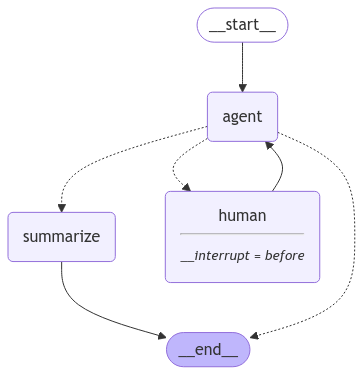

In [58]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [59]:
async def run(message:str):
    event = await graph.ainvoke({"messages": [HumanMessage(content=message)]}, config)
    return event

await run ("hi")

{'messages': [HumanMessage(content='hi', additional_kwargs={}, response_metadata={}, id='5fdc67ba-341c-418d-a7fb-66cebefe1166'),
  AIMessage(content='Hi there! How can I help you today?\n', additional_kwargs={}, response_metadata={}, id='cede1939-e609-4c85-a7c6-c34b62f5b590')],
 'ask_human': False}

In [34]:
snapshot = graph.get_state(config)
snapshot.next

()

In [35]:
existing_message = snapshot.values["messages"][-1]
existing_message.tool_calls

[]

In [ ]:
async def run(message:str):
    event = await graph.ainvoke(None, config)   # pass None so the graph will continue
    return event

await run ("hi")